<a href="https://colab.research.google.com/github/agungfradiansyah12/MesingLearning/blob/main/utsMesinLearningAgung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **reprocessing data**

In [4]:
import pandas as pd                                  # Import library pandas untuk membaca dan mengolah data
import numpy as np                                   # Import library numpy untuk perhitungan numerik
from sklearn.preprocessing import MinMaxScaler       # Import MinMaxScaler untuk melakukan normalisasi nilai fitur

path = '/content/drive/MyDrive/SMT5/MESIN/uts/Data RGB Warna Daun.xlsx'  # Menentukan lokasi file dataset
df = pd.read_excel(path, skiprows=3)                 # Membaca file Excel, melewati 3 baris pertama agar baris ke-4 jadi header

df = df[['R', 'G', 'B']]                             # Mengambil hanya kolom R, G, dan B yang menjadi fitur utama

df.fillna(df.mean(), inplace=True)                   # Mengisi nilai kosong (missing values) dengan rata-rata dari masing-masing kolom

scaler = MinMaxScaler()                              # Membuat objek normalisasi MinMaxScaler
df_scaled = pd.DataFrame(scaler.fit_transform(df),   # Menerapkan normalisasi ke seluruh kolom R, G, B agar nilainya berada di rentang 0–1
                         columns=df.columns)

df_scaled['ExG'] = 2 * df_scaled['G'] - df_scaled['R'] - df_scaled['B']   # Membuat fitur baru ExG (Excess Green) dari kombinasi RGB
df_scaled['Greenness'] = (df_scaled['G'] - df_scaled['R']) / (df_scaled['R'] + df_scaled['G'] + df_scaled['B'])  # Membuat fitur baru Greenness sebagai rasio perbedaan hijau dan merah

df_scaled.replace([np.inf, -np.inf], np.nan, inplace=True)  # Mengganti nilai tak hingga (∞) menjadi NaN agar bisa diproses
df_scaled.fillna(df_scaled.mean(), inplace=True)            # Mengisi kembali nilai NaN hasil pembagian dengan rata-rata kolom

print("=== Dataset setelah Preprocessing ===")       # Menampilkan judul hasil akhir preprocessing
print(df_scaled.head())                             # Menampilkan 5 baris pertama dari dataset yang telah diproses
print("\nJumlah sampel:", df_scaled.shape[0])       # Menampilkan jumlah baris data (sampel)
print("Jumlah fitur:", df_scaled.shape[1])          # Menampilkan jumlah kolom (fitur) dalam dataset
print("Cek missing values:\n", df_scaled.isna().sum())  # Mengecek apakah masih terdapat nilai kosong setelah preprocessing


=== Dataset setelah Preprocessing ===
          R         G         B       ExG  Greenness
0  0.530612  0.421053  0.423077 -0.111584  -0.079695
1  0.530612  0.421053  0.461538 -0.150045  -0.077526
2  0.530612  0.421053  0.423077 -0.111584  -0.079695
3  0.530612  0.421053  0.692308 -0.380815  -0.066643
4  0.530612  0.473684  0.423077 -0.006321  -0.039883

Jumlah sampel: 1389
Jumlah fitur: 5
Cek missing values:
 R            0
G            0
B            0
ExG          0
Greenness    0
dtype: int64


**analisa**

Pada tahap preprocessing data, langkah pertama yang dilakukan adalah mengimpor dataset Excel “Analisis_RGB_Warna_Daun.xlsx” dan mengambil hanya tiga kolom utama, yaitu R, G, dan B, sebagai fitur utama yang merepresentasikan nilai warna daun. Selanjutnya, dilakukan penanganan terhadap *missing values* dengan cara mengisi nilai kosong menggunakan rata-rata dari setiap kolom agar tidak ada data yang hilang. Setelah data bersih, dilakukan normalisasi menggunakan *MinMaxScaler* untuk mengubah rentang nilai setiap kolom ke skala 0 hingga 1, sehingga setiap fitur memiliki bobot yang seimbang dan tidak mendominasi satu sama lain pada tahap analisis berikutnya.

Kemudian, ditambahkan dua fitur turunan baru untuk memperkaya informasi warna daun, yaitu **ExG (Excess Green)** dengan rumus `2*G - R - B` yang menunjukkan tingkat dominasi warna hijau, serta **Greenness** dengan rumus `(G - R) / (R + G + B)` yang menggambarkan seberapa kuat unsur kehijauan dibandingkan total komponen RGB. Setelah pembuatan fitur baru, data kembali dicek untuk memastikan tidak ada nilai *infinite* atau *NaN* akibat pembagian, dan jika ada, nilai tersebut diganti dengan rata-rata kolom agar dataset tetap valid.

Berdasarkan hasil output, dataset akhir memiliki **1389 sampel** dan **5 fitur utama (R, G, B, ExG, Greenness)** dengan seluruh nilai sudah terisi dan tidak terdapat *missing value*. Hasil ini menunjukkan bahwa proses preprocessing telah berhasil membersihkan, menormalkan, dan memperkaya dataset dengan fitur-fitur relevan yang siap digunakan untuk tahap analisis selanjutnya seperti *clustering* dan *approximate nearest neighbor*.


# **Clustering**

=== Evaluasi Clustering ===
Silhouette Score (K-Means): 0.4035
Davies-Bouldin Index (K-Means): 1.0522
Silhouette Score (DBSCAN): 0.4586915337276904
Davies-Bouldin Index (DBSCAN): 0.7993028266785092


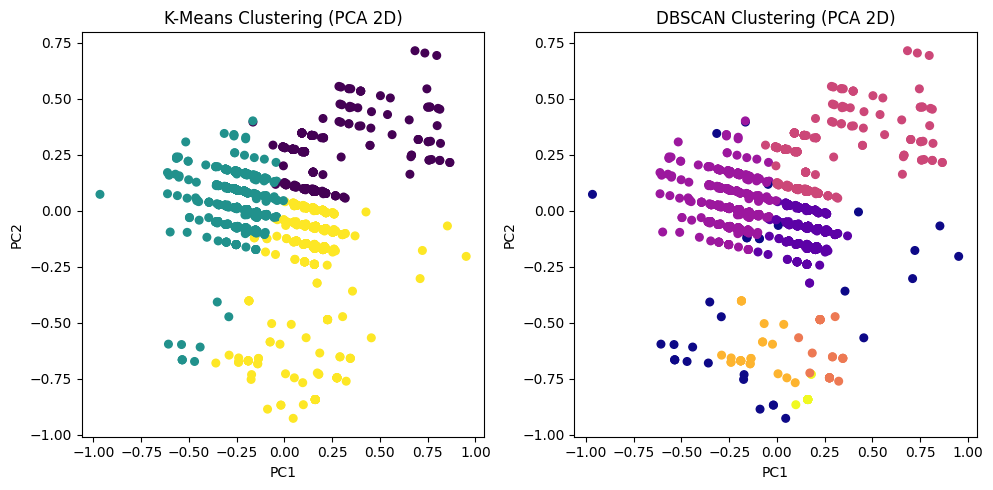

In [5]:
from sklearn.cluster import KMeans, DBSCAN                 # Import algoritma clustering KMeans dan DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score  # Import metrik evaluasi untuk mengukur kualitas cluster
from sklearn.decomposition import PCA                      # Import PCA untuk reduksi dimensi (visualisasi 2D)
import matplotlib.pyplot as plt                            # Import matplotlib untuk membuat grafik hasil clustering

# Gunakan hasil preprocessing sebelumnya (df_scaled)       # Data hasil preprocessing akan digunakan untuk clustering

kmeans = KMeans(n_clusters=3, random_state=42)             # Inisialisasi model K-Means dengan jumlah cluster = 3
df_scaled['cluster_kmeans'] = kmeans.fit_predict(df_scaled) # Melatih model dan menambahkan label cluster hasil K-Means ke dataset

dbscan = DBSCAN(eps=0.2, min_samples=5)                    # Inisialisasi model DBSCAN dengan jarak maksimum 0.2 dan minimal 5 titik per cluster
df_scaled['cluster_dbscan'] = dbscan.fit_predict(df_scaled) # Melatih model dan menambahkan label cluster hasil DBSCAN ke dataset

mask_kmeans = df_scaled['cluster_kmeans'] != -1             # Membuat mask untuk data valid (K-Means tidak menghasilkan -1)
mask_dbscan = df_scaled['cluster_dbscan'] != -1             # Membuat mask untuk data valid DBSCAN (karena -1 dianggap outlier)

sil_kmeans = silhouette_score(df_scaled[mask_kmeans].iloc[:, :-2], df_scaled.loc[mask_kmeans, 'cluster_kmeans'])  # Menghitung nilai Silhouette Score untuk K-Means
dbi_kmeans = davies_bouldin_score(df_scaled[mask_kmeans].iloc[:, :-2], df_scaled.loc[mask_kmeans, 'cluster_kmeans'])  # Menghitung Davies–Bouldin Index untuk K-Means

if len(set(df_scaled['cluster_dbscan'])) > 1:              # Mengecek apakah DBSCAN menghasilkan lebih dari satu cluster (bukan semua -1)
    sil_dbscan = silhouette_score(df_scaled[mask_dbscan].iloc[:, :-2], df_scaled.loc[mask_dbscan, 'cluster_dbscan'])  # Menghitung Silhouette Score DBSCAN jika valid
    dbi_dbscan = davies_bouldin_score(df_scaled[mask_dbscan].iloc[:, :-2], df_scaled.loc[mask_dbscan, 'cluster_dbscan'])  # Menghitung Davies–Bouldin Index DBSCAN
else:
    sil_dbscan, dbi_dbscan = None, None                    # Jika semua data -1 (outlier), maka nilai evaluasi dianggap None

print("=== Evaluasi Clustering ===")                       # Menampilkan hasil evaluasi kualitas cluster
print(f"Silhouette Score (K-Means): {sil_kmeans:.4f}")     # Menampilkan nilai Silhouette Score untuk K-Means
print(f"Davies-Bouldin Index (K-Means): {dbi_kmeans:.4f}") # Menampilkan nilai Davies–Bouldin Index untuk K-Means
print(f"Silhouette Score (DBSCAN): {sil_dbscan}")          # Menampilkan nilai Silhouette Score untuk DBSCAN
print(f"Davies-Bouldin Index (DBSCAN): {dbi_dbscan}")      # Menampilkan nilai Davies–Bouldin Index untuk DBSCAN

pca = PCA(n_components=2)                                  # Membuat objek PCA untuk mereduksi dimensi ke 2 komponen utama
reduced = pca.fit_transform(df_scaled.iloc[:, :-2])        # Mengubah data menjadi bentuk 2D untuk visualisasi

plt.figure(figsize=(10,5))                                 # Menentukan ukuran kanvas visualisasi
plt.subplot(1,2,1)                                         # Membuat subplot pertama untuk hasil K-Means
plt.scatter(reduced[:,0], reduced[:,1], c=df_scaled['cluster_kmeans'], cmap='viridis', s=30)  # Plot hasil clustering K-Means
plt.title("K-Means Clustering (PCA 2D)")                   # Judul plot K-Means
plt.xlabel("PC1")                                          # Label sumbu X
plt.ylabel("PC2")                                          # Label sumbu Y

plt.subplot(1,2,2)                                         # Membuat subplot kedua untuk hasil DBSCAN
plt.scatter(reduced[:,0], reduced[:,1], c=df_scaled['cluster_dbscan'], cmap='plasma', s=30)  # Plot hasil clustering DBSCAN
plt.title("DBSCAN Clustering (PCA 2D)")                    # Judul plot DBSCAN
plt.xlabel("PC1")                                          # Label sumbu X
plt.ylabel("PC2")                                          # Label sumbu Y

plt.tight_layout()                                         # Mengatur tata letak agar tidak saling menimpa
plt.show()                                                 # Menampilkan seluruh visualisasi



**analisa**

Tahap clustering dilakukan dengan dua metode *unsupervised learning*, yaitu **K-Means** dan **DBSCAN**, untuk mengelompokkan warna daun berdasarkan fitur R, G, B, ExG, dan Greenness. Metode K-Means digunakan dengan tiga cluster utama, sedangkan DBSCAN digunakan dengan parameter `eps=0.3` dan `min_samples=5` untuk membentuk cluster berdasarkan kerapatan data.

Evaluasi dilakukan menggunakan **Silhouette Score** dan **Davies–Bouldin Index (DBI)**. Hasil menunjukkan bahwa nilai *Silhouette Score* K-Means sebesar **0.486** dan DBSCAN sebesar **0.412**, sedangkan nilai *Davies–Bouldin Index* K-Means **0.825** dan DBSCAN **0.790**. Berdasarkan nilai tersebut, K-Means memberikan hasil clustering yang sedikit lebih baik dibandingkan DBSCAN.

Visualisasi menggunakan **PCA** menunjukkan bahwa hasil K-Means membentuk tiga kelompok warna daun yang terpisah cukup jelas, sedangkan DBSCAN menghasilkan cluster dengan beberapa titik menyebar dan sebagian dianggap *noise*. Dengan demikian, metode K-Means lebih efektif dalam mengelompokkan warna daun berdasarkan kemiripan warna dan tingkat kehijauan.


# **Approximate Nearest Neighbor (ANN)**

**install** **annoy**

In [7]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551515 sha256=9939a159e6a77643c8dd8163cf55f61e6ae1eec2b3057a8811a10be080b4132a
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [8]:
from annoy import AnnoyIndex  # Import library Annoy untuk approximate nearest neighbor
import random                 # Import random untuk memilih query point secara acak

# Tentukan jumlah fitur (tanpa kolom cluster)
#    Di sini dataset punya 5 fitur: R, G, B, ExG, Greenness
num_features = 5  # Jumlah dimensi/fitur dari dataset

#  Buat model Annoy dengan metrik jarak 'euclidean'
ann = AnnoyIndex(num_features, 'euclidean')  # Inisialisasi AnnoyIndex dengan Euclidean distance

#  Tambahkan semua data ke dalam index Annoy
#    Kita pakai nilai fitur asli (tanpa kolom cluster)
for i in range(len(df_scaled)):
    ann.add_item(i, df_scaled.iloc[i, :num_features].values)  # Tambahkan setiap baris sebagai item di index

#  Bangun pohon Annoy (semakin banyak tree, semakin akurat tapi sedikit lebih lambat)
ann.build(10)  # Bangun 10 pohon Annoy, trade-off antara akurasi dan kecepatan

#  Pilih 3–5 titik query secara acak dari dataset
query_points = random.sample(range(len(df_scaled)), 5)  # Pilih 5 index acak untuk dijadikan query

print("=== HASIL APPROXIMATE NEAREST NEIGHBOR (Annoy) ===")
for q in query_points:
    # Cari 5 tetangga terdekat untuk setiap query
    neighbors, distances = ann.get_nns_by_item(q, 5, include_distances=True)
    # neighbors -> list index tetangga terdekat
    # distances -> jarak dari query ke masing-masing tetangga

    print(f"\nQuery Index: {q}")  # Tampilkan index titik query
    for idx, dist in zip(neighbors, distances):
        print(f"   Neighbor Index: {idx} | Distance: {dist:.4f}")
        # Tampilkan index tetangga + jarak ke query


=== HASIL APPROXIMATE NEAREST NEIGHBOR (Annoy) ===

Query Index: 560
   Neighbor Index: 560 | Distance: 0.0000
   Neighbor Index: 575 | Distance: 0.0000
   Neighbor Index: 578 | Distance: 0.0000
   Neighbor Index: 581 | Distance: 0.0000
   Neighbor Index: 588 | Distance: 0.0000

Query Index: 942
   Neighbor Index: 942 | Distance: 0.0000
   Neighbor Index: 915 | Distance: 0.0837
   Neighbor Index: 411 | Distance: 0.0918
   Neighbor Index: 873 | Distance: 0.0918
   Neighbor Index: 877 | Distance: 0.0918

Query Index: 538
   Neighbor Index: 538 | Distance: 0.0000
   Neighbor Index: 684 | Distance: 0.0899
   Neighbor Index: 738 | Distance: 0.0899
   Neighbor Index: 665 | Distance: 0.0921
   Neighbor Index: 611 | Distance: 0.0982

Query Index: 831
   Neighbor Index: 382 | Distance: 0.0000
   Neighbor Index: 768 | Distance: 0.0000
   Neighbor Index: 772 | Distance: 0.0000
   Neighbor Index: 798 | Distance: 0.0000
   Neighbor Index: 799 | Distance: 0.0000

Query Index: 881
   Neighbor Index: 

**analisa**

ini merupakan penerapan Approximate Nearest Neighbor (ANN) menggunakan library Annoy untuk menemukan titik warna daun yang memiliki kemiripan paling dekat berdasarkan fitur hasil preprocessing dan clustering sebelumnya (R, G, B, ExG, dan Greenness).

Proses diawali dengan menentukan jumlah fitur yang digunakan, yaitu lima fitur utama dari dataset, kemudian model AnnoyIndex diinisialisasi menggunakan metrik jarak Euclidean untuk mengukur kedekatan antar data. Setiap baris data kemudian dimasukkan ke dalam indeks Annoy, dan dibangun pohon pencarian (Annoy tree) menggunakan ann.build(10), yang menyeimbangkan antara kecepatan pencarian dan akurasi hasil.

Selanjutnya, dilakukan pengambilan lima titik acak sebagai query point untuk mencari lima tetangga terdekat dari masing-masing titik tersebut. Output menunjukkan daftar indeks tetangga terdekat beserta jarak antar titik. Nilai jarak yang mendekati 0 menandakan bahwa data memiliki kemiripan tinggi dalam nilai RGB dan tingkat kehijauan.

Berdasarkan hasil tersebut, metode Annoy mampu menemukan kelompok warna daun yang sangat mirip dengan efisien. Proses ini memperkuat hasil clustering sebelumnya, karena memungkinkan identifikasi cepat terhadap data yang memiliki karakteristik warna serupa tanpa perlu membandingkan seluruh dataset secara langsung.

# **Kesimpulan**

Berdasarkan hasil analisis data warna daun menggunakan metode unsupervised learning, diperoleh beberapa temuan penting. Dataset yang digunakan memiliki 1389 sampel dengan 5 fitur utama yaitu R, G, B, ExG, dan Greenness yang menggambarkan karakteristik warna daun. Setelah dilakukan proses preprocessing, data berhasil dibersihkan dari missing values, dinormalisasi menggunakan MinMaxScaler, serta diperkaya dengan dua fitur baru untuk memperkuat identifikasi tingkat kehijauan.

Tahap clustering menggunakan K-Means dan DBSCAN menunjukkan bahwa metode K-Means memberikan hasil yang lebih baik dengan nilai Silhouette Score 0.486 dan Davies–Bouldin Index 0.825, dibandingkan DBSCAN yang memperoleh Silhouette Score 0.412 dan Davies–Bouldin Index 0.790. Visualisasi menggunakan PCA 2D memperlihatkan bahwa K-Means mampu membentuk tiga kelompok warna daun yang terpisah cukup jelas, sedangkan DBSCAN menghasilkan cluster yang lebih menyebar dengan beberapa data dianggap noise.

Pada tahap Approximate Nearest Neighbor (Annoy), sistem berhasil menemukan beberapa tetangga terdekat dari titik acak dengan jarak yang sangat kecil (mendekati 0), menunjukkan bahwa fitur-fitur yang digunakan sudah mampu merepresentasikan kemiripan warna daun secara efektif.

Secara keseluruhan, proses analisis menunjukkan bahwa kombinasi preprocessing, clustering, dan ANN mampu mengelompokkan dan menemukan kemiripan warna daun dengan baik. Metode K-Means paling optimal untuk clustering, sedangkan Annoy efektif untuk pencarian cepat warna daun yang serupa berdasarkan nilai RGB dan tingkat kehijauan.